In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

## Load and inspect data

In [2]:
# loading data
original_data = pd.read_csv('./data/CMU_Data_AllMonths.txt', sep='|')

In [3]:
original_data.head(2)

,ID,Month_End_D,Customer_ID,Region,LOB,INDUSTRY_CODE,Monthly_Revenue,Rolling12_Revenue,TENURE_IN_MONTHS,DEPOSIT_ACCT_CNT,GL_BAL_S,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,SRVC_ACCT_TRNS_CNT,MIN_PRMRY_CUST_OPEN_D,MAX_PRMRY_CUST_CLSD_D
0,18327740,31DEC2017,1,Region 1,None,Industry 1,nan,nan,562.00,29.00,230499.19,7243.00,732342015.48,537119.00,0.00,15FEB1971,31DEC9999
1,15032822,31JAN2019,1,Region 1,None,Industry 1,nan,nan,575.00,25.00,412883.71,6871.00,432884988.46,606733.00,21.00,15FEB1971,31DEC9999


## Data Wrangling

In [4]:
# create a numeric month column from column Month_End_D
original_data['month'] = pd.to_datetime(original_data['Month_End_D'], format='%d%b%Y').apply(lambda x: x.strftime('%Y-%m'))

# create a numeric Cust_Open_Date date column from column MIN_PRMRY_CUST_OPEN_D
original_data['cust_open_date'] = pd.to_datetime(original_data['MIN_PRMRY_CUST_OPEN_D'], format='%d%b%Y')

# create a new customer churn label column based on closing date column (0 means customer did not churn during that month)
original_data['churn_label'] = original_data['MAX_PRMRY_CUST_CLSD_D'].apply(lambda x: 0 if x == '31DEC9999' else 1)

# create a numeric Cust_Clsd_Date date column from column MAX_PRMRY_CUST_CLSD_D
# note: closed date is null if MAX_PRMRY_CUST_CLSD_D = 31DEC9999
original_data['cust_clsd_date'] = pd.to_datetime(original_data[original_data['churn_label'] == 1]['MAX_PRMRY_CUST_CLSD_D'], format='%d%b%Y')

# drop columns that we don't need
original_data.drop(columns=['Month_End_D', 'MIN_PRMRY_CUST_OPEN_D', 'MAX_PRMRY_CUST_CLSD_D'], inplace=True)

In [5]:
# rearrange columns
original_data = original_data[['month','ID','Customer_ID','cust_open_date','Region','LOB','INDUSTRY_CODE','Monthly_Revenue','Rolling12_Revenue',
                               'TENURE_IN_MONTHS','DEPOSIT_ACCT_CNT','GL_BAL_S', 'LOAN_ACCT_CNT', 'LOAN_BAL_S', 'SRVC_ACCT_CNT',
                              'SRVC_ACCT_TRNS_CNT','cust_clsd_date','churn_label']]

In [6]:
# missing datetime values can cause problems in doing certain operations. imputing missing datetime values with 1/1/1
original_data['cust_clsd_date'] = original_data['cust_clsd_date'].apply(lambda x: datetime.min.date() if pd.isnull(x) else x.date())
original_data['cust_open_date'] = original_data['cust_open_date'].apply(lambda x: datetime.min.date() if pd.isnull(x) else x.date())

In [7]:
original_data.sort_values(by=['Customer_ID', 'month'], ascending=['True', 'True'], inplace=True)
original_data.head(5)

,month,ID,Customer_ID,cust_open_date,Region,LOB,INDUSTRY_CODE,Monthly_Revenue,Rolling12_Revenue,TENURE_IN_MONTHS,DEPOSIT_ACCT_CNT,GL_BAL_S,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,SRVC_ACCT_TRNS_CNT,cust_clsd_date,churn_label
7,2017-01,21183544,1,1971-02-15,Region 1,None,Industry 1,nan,nan,551.00,27.00,159834.61,7627.00,326723187.11,480768.00,0.00,0001-01-01,0
9,2017-04,20387751,1,1971-02-15,Region 1,None,Industry 1,nan,nan,554.00,30.00,209683.20,7067.00,511475671.50,495657.00,0.00,0001-01-01,0
13,2017-05,20122299,1,1971-02-15,Region 1,None,Industry 1,nan,nan,555.00,30.00,214700.17,6163.00,92762589.50,497413.00,0.00,0001-01-01,0
0,2017-12,18327740,1,1971-02-15,Region 1,None,Industry 1,nan,nan,562.00,29.00,230499.19,7243.00,732342015.48,537119.00,0.00,0001-01-01,0
3,2018-01,18073577,1,1971-02-15,Region 1,None,Industry 1,nan,nan,563.00,28.00,234071.10,7860.00,251859315.81,541082.00,0.00,0001-01-01,0


##### We can see that there are missing rows for a customer. We'll clean the data later

## Summary Statistics & Exploratory Data Analytics

In [8]:
# number of rows and columns in the dataset
original_data.shape

(7983742, 18)

In [9]:
original_data.nunique()

month                      31
ID                    7983742
Customer_ID            363481
cust_open_date          17048
Region                     56
LOB                         7
INDUSTRY_CODE              25
Monthly_Revenue       1247484
Rolling12_Revenue     1346178
TENURE_IN_MONTHS         1392
DEPOSIT_ACCT_CNT          461
GL_BAL_S              3450422
LOAN_ACCT_CNT             591
LOAN_BAL_S            1313363
SRVC_ACCT_CNT             742
SRVC_ACCT_TRNS_CNT        763
cust_clsd_date           1517
churn_label                 2
dtype: int64

###### 31 Months of Data
###### 56 Regions
###### 7 Lines of Business
###### 25 Industries
###### 363481 Unique Customers in the Dataset

In [10]:
# descriptive statistics for the month of June 2019
original_data[original_data['month']=='2019-06'].describe()

,ID,Customer_ID,Monthly_Revenue,Rolling12_Revenue,TENURE_IN_MONTHS,DEPOSIT_ACCT_CNT,GL_BAL_S,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,SRVC_ACCT_TRNS_CNT,churn_label
count,262578.00,262578.00,257395.00,259821.00,260969.00,262537.00,262537.00,262537.00,262537.00,262537.00,262537.00,262578.00
mean,13860090.50,181755.34,1322.29,14107.82,177.38,1.65,116934.23,24.45,9984942.77,3246.85,0.28,0.03
std,75799.88,104932.59,34637.13,315288.71,172.53,5.63,3390475.11,323.94,136526105.75,44959.10,24.33,0.16
min,13728802.00,2.00,-1056364.65,-40572893.09,-1.00,0.00,-1499427.58,0.00,-32492.10,0.00,0.00,0.00
25%,13794446.25,90885.25,10.50,133.85,47.00,1.00,424.14,0.00,0.00,0.00,0.00,0.00
50%,13860090.50,181717.50,38.95,481.35,128.00,1.00,5013.12,0.00,0.00,1.00,0.00,0.00
75%,13925734.75,272587.75,159.80,1836.24,264.00,2.00,28393.97,1.00,50.87,2.00,0.00,0.00
max,13991379.00,363478.00,8830097.17,108203854.81,1433.00,1294.00,1277651784.60,4511.00,1903379614.20,626055.00,10372.00,1.00


##### Do the maximum and minimum values of certain features make sense, or are these outliers?
##### Percentage churn in the month of June 2019 ~3%

In [11]:
# LOB comparison using the data of June 2019
original_data[original_data['month']=='2019-06'].groupby('LOB').agg({"Customer_ID":"count", "Monthly_Revenue":"mean", "TENURE_IN_MONTHS":"mean",
                                                                    "DEPOSIT_ACCT_CNT":"mean","GL_BAL_S":"mean","LOAN_ACCT_CNT":"mean",
                                                                     "LOAN_BAL_S":"mean", "SRVC_ACCT_CNT":"mean","SRVC_ACCT_TRNS_CNT":"mean",
                                                                     "churn_label":"mean"})

,TENURE_IN_MONTHS,Monthly_Revenue,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,GL_BAL_S,churn_label,Customer_ID,SRVC_ACCT_TRNS_CNT,DEPOSIT_ACCT_CNT
LOB,,,,,,,,,,
LOB 1,173.61,128.46,1.64,355612.34,119.87,38980.27,0.03,237373,0.06,1.49
LOB 2,222.45,2653.63,2.90,465662.75,73.66,367176.90,0.01,8782,0.22,2.29
LOB 3,247.60,16293.74,9.28,3922513.26,432.15,1717134.19,0.02,4461,1.07,3.00
LOB 4,285.39,6095.08,26.39,9690618.77,3212.15,96692.32,0.47,195,27.51,0.46
LOB 5,342.89,2364.27,1659.68,700572424.83,230167.60,918099.54,0.05,2183,9.91,9.96
LOB 6,157.36,22359.54,245.20,103278474.36,33405.10,892775.55,0.03,9584,2.57,2.55


##### Although LOB 4 has the highest churn rate of 47%, there are only 195 customers in LOB 4
##### LOB 1 is the biggest line of business in terms of the number of customers
##### LOB 3 and LOB 6 have the highest monthly revenue per customer

In [12]:
# Industry comparison using the data of June 2019
original_data[original_data['month']=='2019-06'].groupby('INDUSTRY_CODE').agg({"Customer_ID":"count", "Monthly_Revenue":"mean", "TENURE_IN_MONTHS":"mean",
                                                                    "DEPOSIT_ACCT_CNT":"mean","GL_BAL_S":"mean","LOAN_ACCT_CNT":"mean",
                                                                     "LOAN_BAL_S":"mean", "SRVC_ACCT_CNT":"mean","SRVC_ACCT_TRNS_CNT":"mean",
                                                                     "churn_label":"mean"}).sort_values(by="churn_label", ascending=False).head(20)

,TENURE_IN_MONTHS,Monthly_Revenue,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,GL_BAL_S,churn_label,Customer_ID,SRVC_ACCT_TRNS_CNT,DEPOSIT_ACCT_CNT
INDUSTRY_CODE,,,,,,,,,,
Industry 25,394.12,6395.09,2.59,1470770.40,4.71,1778667.41,0.05,153,2.13,6.33
Industry 18,255.89,2801.02,3.74,304758.82,0.46,232250.28,0.03,61,0.00,1.05
Industry 1,170.15,1174.42,25.82,10613145.41,3463.05,105603.06,0.03,246172,0.28,1.64
Industry 22,322.53,5541.71,4.08,900267.73,7.33,387558.64,0.02,250,0.00,2.00
Industry 13,271.18,2827.62,2.51,593013.21,2.37,66745.88,0.02,49,4.31,1.41
Industry 15,260.24,12349.71,7.15,1699556.26,1.13,785900.26,0.02,533,0.97,1.66
Industry 16,278.08,2464.87,3.20,728877.21,1.09,222485.38,0.02,831,0.18,1.70
Industry 3,293.65,20257.78,31.21,3667755.55,1.69,402316.32,0.02,62,0.00,1.18
Industry 24,295.85,922.94,2.45,127906.24,2.09,150744.54,0.01,1534,0.00,1.52


In [13]:
# Region comparison using the data of June 2019
original_data[original_data['month']=='2019-06'].groupby('Region').agg({"Customer_ID":"count", "Monthly_Revenue":"mean", "TENURE_IN_MONTHS":"mean",
                                                                    "DEPOSIT_ACCT_CNT":"mean","GL_BAL_S":"mean","LOAN_ACCT_CNT":"mean",
                                                                     "LOAN_BAL_S":"mean", "SRVC_ACCT_CNT":"mean","SRVC_ACCT_TRNS_CNT":"mean",
                                                                     "churn_label":"mean"}).sort_values(by="churn_label", ascending=False).head(20)

,TENURE_IN_MONTHS,Monthly_Revenue,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,GL_BAL_S,churn_label,Customer_ID,SRVC_ACCT_TRNS_CNT,DEPOSIT_ACCT_CNT
Region,,,,,,,,,,
Region 1,202.92,17013.72,446.64,188383676.28,61478.08,851461.90,0.04,13388,3.86,3.60
Region 41,115.87,109.69,0.92,160720.84,54.50,32319.32,0.04,11766,0.00,1.36
Region 40,160.32,117.38,2.93,884457.65,301.37,35709.99,0.04,10433,0.01,1.40
Region 47,163.98,127.56,1.28,232811.23,78.61,35587.23,0.03,16225,0.00,1.43
Region 43,169.98,124.10,0.91,82058.55,27.41,40597.73,0.03,24112,0.53,1.40
Region 46,153.22,205.23,2.41,683969.70,231.99,45880.58,0.03,10855,0.01,1.37
Region 49,258.89,120.72,2.76,764279.11,259.88,38767.59,0.03,9697,0.01,1.56
Region 52,159.52,151.65,1.36,280078.72,94.20,54652.34,0.03,26973,0.02,1.55
Region 50,157.75,142.90,2.22,620483.32,210.28,46934.78,0.03,17977,0.01,1.48


##### Regions 1, 41 and 40 have higher churn rates in June 2019 as compared to other regions

In [14]:
# number of customers with missing open dates
temp_group = original_data.groupby('Customer_ID', as_index=False).agg({'cust_open_date':'max'})
print("No. of customers with missing open date: ", len(temp_group[temp_group['cust_open_date']==datetime.min.date()]))
del temp_group

No. of customers with missing open date:  3873


## DATA CLEANING

As we determined earlier that there are customers with missing rows, we'll proceed to remove those customers from the dataset.
Missing rows (that is, missing months) for a customer creates problem in churn analysis as well as when we'll use lead/ lag functions.
We'll call customers with missing rows as customers having non-continuous data

Below we'll find customers with non-continuous data

In [15]:
def num_months_ideal(s):
    """
    This function returns the number of months of data that should be available for a customer assuming there is no missing data.
    Note: There are hard-coded values in the function. Re-use of this function on an updated or different dataset will require some changes
    """
# if missing opening dates, return NaN
    if s['opening_date']==datetime.min.date().strftime('%Y-%m'):
        return np.NaN
# if no closing date and opening date is before Jan 2017, return 31 (all months should be present)
    elif s['closing_date']==datetime.min.date().strftime('%Y-%m') and s['opening_date']< '2017-01':
        return (2019-2017)*12 + (7-1) + 1
# if no closing date and opening date is on or after Jan 2017
    elif s['closing_date']==datetime.min.date().strftime('%Y-%m') and s['opening_date'] >= '2017-01':
        first_year, first_month = s['opening_date'].split('-')
        return (2019 - int(first_year))*12 + (7-int(first_month)) + 1
# if closing date is avaialble and opening date before Jan 2017
    elif s['closing_date'] != datetime.min.date().strftime('%Y-%m') and s['opening_date'] < '2017-01':
        last_year, last_month = s['closing_date'].split('-')
        return (int(last_year)-2017)*12 + (int(last_month)-1) + 1
# if closing date is avaialble and opening date is on or after Jan 2017
    else:
        last_year, last_month = s['closing_date'].split('-')
        first_year, first_month = s['opening_date'].split('-')
        return (int(last_year) - int(first_year))*12 + (int(last_month)-int(first_month)) + 1

In [16]:
# find first month, last month, row count, opening date and closing date for a customer
grouped_data = original_data.groupby('Customer_ID', as_index=False).agg(
                            OrderedDict([("cust_clsd_date","max"), ("month",['min','max', 'count']), ("cust_open_date","min")]))

In [17]:
grouped_data.columns = ["cust_id", "closing_date", "month_first", "month_last", "num_month_data_available", "opening_date"] # rename columns
grouped_data["closing_date"] = grouped_data["closing_date"].apply(lambda x: x.strftime('%Y-%m')) # Extract month and year
grouped_data["opening_date"] = grouped_data["opening_date"].apply(lambda x: x.strftime('%Y-%m')) # Extract month and year
grouped_data['num_months_ideal'] = grouped_data.apply(num_months_ideal, axis=1) # Add num_months_ideal column using the num_months_ideal func
grouped_data.head(2)

,cust_id,closing_date,month_first,month_last,num_month_data_available,opening_date,num_months_ideal
0,1,1-01,2017-01,2019-01,17,1971-02,31.00
1,2,1-01,2017-01,2019-07,31,2010-03,31.00


In [18]:
# customer ids with non-continuous data
cust_id_non_continuous = set(grouped_data[grouped_data['num_month_data_available']!=grouped_data['num_months_ideal']].cust_id)
del grouped_data
print("Number of unique customers with missing rows: ", len(cust_id_non_continuous))

Number of unique customers with missing rows:  113775


In [19]:
# clean data = data with customers having no missing months in between
clean_data = original_data[~original_data['Customer_ID'].isin(list(cust_id_non_continuous))]
print("No. of customers in clean data: ", clean_data.Customer_ID.nunique())

No. of customers in clean data:  249706


In [20]:
clean_data.nunique()

month                      31
ID                    6195937
Customer_ID            249706
cust_open_date          15649
Region                     44
LOB                         7
INDUSTRY_CODE              25
Monthly_Revenue        980034
Rolling12_Revenue     1102163
TENURE_IN_MONTHS         1335
DEPOSIT_ACCT_CNT          439
GL_BAL_S              2935342
LOAN_ACCT_CNT             567
LOAN_BAL_S            1019672
SRVC_ACCT_CNT             666
SRVC_ACCT_TRNS_CNT        518
cust_clsd_date            688
churn_label                 2
dtype: int64

##### There are only 44 regions left in the clean data. We'll be using this clean data to train our model.
#### While making a prediction, test data should not contain any region other than these 44 regions

## FEATURE IDENTIFICATION & FEATURE ENGINEERING

It is safe to assume that features of a customer 12 months before he got churned would add little value to the prediction of churn. Hence we extract only the last 12 months data of each customer. We'll work with clean data for now

In [21]:
# extracts last 12 month of data of each customer. this includes data of the current month (if the customer did not churn) or
# data of the month in which the customer got churned
last12 = clean_data.sort_values(['Customer_ID','month'],ascending=[True,False]).groupby('Customer_ID').head(12)

# generates a new month number column
last12['month_num_from_end']=last12.sort_values(['Customer_ID','month'],ascending=[True,False]).groupby('Customer_ID').cumcount()

# drop columns we don't need. we don't need cust_open_date because we have the tenure of the customer
last12.drop(columns=['month', 'ID', 'cust_open_date','cust_clsd_date'], inplace=True)

last12.head(5)

,Customer_ID,Region,LOB,INDUSTRY_CODE,Monthly_Revenue,Rolling12_Revenue,TENURE_IN_MONTHS,DEPOSIT_ACCT_CNT,GL_BAL_S,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,SRVC_ACCT_TRNS_CNT,churn_label,month_num_from_end
37,2,Region 50,LOB 1,Industry 1,44.45,376.92,112.00,0.00,0.00,1.00,0.00,5.00,0.00,0,0
36,2,Region 50,LOB 1,Industry 1,58.39,360.82,111.00,0.00,0.00,1.00,0.00,5.00,0.00,0,1
23,2,Region 50,LOB 1,Industry 1,35.18,328.34,110.00,0.00,0.00,1.00,0.00,5.00,0.00,0,2
40,2,Region 50,LOB 1,Industry 1,34.09,311.21,109.00,0.00,0.00,1.00,0.00,5.00,0.00,0,3
42,2,Region 50,LOB 1,Industry 1,39.23,293.70,108.00,0.00,0.00,1.00,0.00,5.00,0.00,0,4


Let's calculate the average percent change of some features for each customer w.r.t month. Esentially, we are trying to create new features.
Although the current features incorporate the information that we'll add as a new feature, explicitly adding new relevant features can improve the accuracy.

In [22]:
############## creating lagged features to calculate percent change with month ######################

last12['Monthly_Revenue_lagged'] = last12.sort_values(by=['month_num_from_end'], ascending=False
                                                     ).groupby(['Customer_ID'])['Monthly_Revenue'].shift(1) # the ordering of the months if from oldest to latest

last12['LOAN_BAL_S_lagged'] = last12.sort_values(by=['month_num_from_end'], ascending=False
                                                ).groupby(['Customer_ID'])['LOAN_BAL_S'].shift(1)

last12['GL_BAL_S_lagged'] = last12.sort_values(by=['month_num_from_end'], ascending=False
                                              ).groupby(['Customer_ID'])['GL_BAL_S'].shift(1)

################## calculating percent change with month ######################################

last12['Monthly_Revenue_percent_change'] = (last12['Monthly_Revenue'] - last12['Monthly_Revenue_lagged']) / last12['Monthly_Revenue_lagged']

last12['LOAN_BAL_S_percent_change'] = (last12['LOAN_BAL_S'] - last12['LOAN_BAL_S_lagged']) / last12['LOAN_BAL_S_lagged']

last12['GL_BAL_S_percent_change'] = (last12['GL_BAL_S'] - last12['GL_BAL_S_lagged']) / last12['GL_BAL_S_lagged']

################ replace infinitt values with np.nan and drop unnecessary columns

last12.replace(np.inf, np.nan, inplace=True)

last12.replace(-np.inf, np.nan, inplace=True)

# drop columns which are not required
last12.drop(columns=['Monthly_Revenue_lagged','LOAN_BAL_S_lagged','GL_BAL_S_lagged'], inplace=True)

last12.head(2)

,Customer_ID,Region,LOB,INDUSTRY_CODE,Monthly_Revenue,Rolling12_Revenue,TENURE_IN_MONTHS,DEPOSIT_ACCT_CNT,GL_BAL_S,LOAN_ACCT_CNT,LOAN_BAL_S,SRVC_ACCT_CNT,SRVC_ACCT_TRNS_CNT,churn_label,month_num_from_end,Monthly_Revenue_percent_change,LOAN_BAL_S_percent_change,GL_BAL_S_percent_change
37,2,Region 50,LOB 1,Industry 1,44.45,376.92,112.00,0.00,0.00,1.00,0.00,5.00,0.00,0,0,-0.24,nan,nan
36,2,Region 50,LOB 1,Industry 1,58.39,360.82,111.00,0.00,0.00,1.00,0.00,5.00,0.00,0,1,0.66,nan,nan


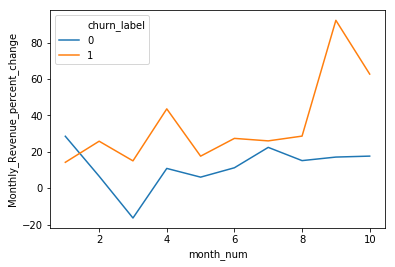

In [23]:
line_plot_temp_df = last12[last12['month_num_from_end']!=0].groupby(['churn_label','month_num_from_end'], as_index=False)['Monthly_Revenue_percent_change'].mean()
line_plot_temp_df['month_num'] = line_plot_temp_df.sort_values(by='month_num_from_end', ascending=False).groupby('churn_label').cumcount()
line_plot_temp_df.drop(columns=['month_num_from_end'], inplace=True)
sns.lineplot(data=line_plot_temp_df, hue='churn_label', x='month_num', y='Monthly_Revenue_percent_change')
del line_plot_temp_df

#### We can see that there is a start difference between the percent change in monthly revenue of churned vs. non-churned customers (last 12 month data)
#### This can be an important feature for prediction of churn.

month_num_from_end 0 is the current month if the customer does not get churned  
month_num_from_end 0 is the month when the customer gets churned if he gets churned  
so, we will not include this data for prediction  
also, we should atleast predict 1 month in advance to proactively take action to retain the customer  
so, we will not include data where month_num_from_end is 1

In [24]:
# remove all rows where month_num_from_end is 0 or 1
last12 = last12[last12['month_num_from_end'] != 0]
last12 = last12[last12['month_num_from_end'] != 1]

## PIVOT TABLE

In [41]:
pivot_columns_1 = list(last12.columns)
pivot_columns_1.remove('Customer_ID') # Customer_ID will be the index. So, no need to pivot it
# we'll seperately pivot below columns and merge it later
pivot_columns_1.remove('Region')
pivot_columns_1.remove('LOB')
pivot_columns_1.remove('INDUSTRY_CODE')
pivot_columns_1.remove('churn_label')           
pivot_columns_1.remove('month_num_from_end')
pivot_columns_1.remove('TENURE_IN_MONTHS')
pivot_columns_2 = ['Region', 'LOB', 'INDUSTRY_CODE', 'churn_label', 'TENURE_IN_MONTHS']

In [42]:
pivot = last12.pivot(index='Customer_ID', columns='month_num_from_end', values=pivot_columns_1)
pivot.head(2)

Monthly_Revenue                                             \
month_num_from_end              2     3     4      5     6     7     8     9    
Customer_ID                                                                     
2                            35.18 34.09 39.23  26.10 38.67 12.96 14.10 16.69   
8                             1.05  1.57  2.10 151.33  3.15  3.66  4.17  4.67   

                                Rolling12_Revenue                              \
month_num_from_end    10     11                2      3      4      5      6    
Customer_ID                                                                     
2                  24.76 331.23            328.34 311.21 293.70 294.96 298.66   
8                   5.17   5.65               nan    nan    nan    nan  70.48   

                                          DEPOSIT_ACCT_CNT                 \
month_num_from_end     7   8   9   10  11               2    3    4    5    
Customer_ID                                                                 
2                  288.35 nan nan nan nan             0.00 0.00 0.00 0.00   
8                     nan nan nan nan nan             0.00 0.00 0.00 0.00   

                                                 GL_BAL_S                      \
month_num_from_end   6    7    8    9    10   11       2    3    4    5    6    
Customer_ID                                                                     
2                  0.00 0.00 0.00 0.00 0.00 0.00     0.00 0.00 0.00 0.00 0.00   
8                  0.00 0.00 0.00 0.00 0.00 0.00     0.00 0.00 0.00 0.00 0.00   

                                            LOAN_ACCT_CNT                      \
month_num_from_end   7    8    9    10   11            2    3    4    5    6    
Customer_ID                                                                     
2                  0.00 0.00 0.00 0.00 0.00          1.00 1.00 1.00 1.00 0.00   
8                  0.00 0.00 0.00 0.00 0.00          1.00 1.00 1.00 1.00 1.00   

                                            LOAN_BAL_S                       \
month_num_from_end   7    8    9    10   11         2      3      4      5    
Customer_ID                                                                   
2                  0.00 0.00 0.00 0.00 0.00       0.00   0.00   0.00   0.00   
8                  1.00 1.00 1.00 1.00 1.00     202.83 303.28 403.10 502.30   

                                                              SRVC_ACCT_CNT  \
month_num_from_end     6      7      8      9      10      11            2    
Customer_ID                                                                   
2                    0.00   0.00   0.00   0.00   0.00    0.00          5.00   
8                  600.88 698.84 796.19 892.93 989.08 1084.63          0.00   

                                                                 \
month_num_from_end   3    4    5    6    7    8    9    10   11   
Customer_ID                                                       
2                  5.00 5.00 5.00 5.00 5.00 5.00 5.00 5.00 5.00   
8                  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

                   SRVC_ACCT_TRNS_CNT                                          \
month_num_from_end                 2    3    4    5    6    7    8    9    10   
Customer_ID                                                                     
2                                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   
8                                0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00   

                        Monthly_Revenue_percent_change                    \
month_num_from_end   11                             2     3     4     5    
Customer_ID                                                                
2                  0.00                           0.03 -0.13  0.50 -0.33   
8                  0.00                          -0.33 -0.25 -0.99 47.11   

                                                      \
month_num_from_end    6     7     8   

In [43]:
# rename pivot columns
new_col_names = []

for col in pivot.columns:
    new_col_names.append(str(col[0]) + '_' + str(col[1]))

pivot.columns = new_col_names
pivot = pivot.reset_index(drop=False)
pivot.head(2)

,Customer_ID,Monthly_Revenue_2,Monthly_Revenue_3,Monthly_Revenue_4,Monthly_Revenue_5,Monthly_Revenue_6,Monthly_Revenue_7,Monthly_Revenue_8,Monthly_Revenue_9,Monthly_Revenue_10,Monthly_Revenue_11,Rolling12_Revenue_2,Rolling12_Revenue_3,Rolling12_Revenue_4,Rolling12_Revenue_5,Rolling12_Revenue_6,Rolling12_Revenue_7,Rolling12_Revenue_8,Rolling12_Revenue_9,Rolling12_Revenue_10,Rolling12_Revenue_11,DEPOSIT_ACCT_CNT_2,DEPOSIT_ACCT_CNT_3,DEPOSIT_ACCT_CNT_4,DEPOSIT_ACCT_CNT_5,DEPOSIT_ACCT_CNT_6,DEPOSIT_ACCT_CNT_7,DEPOSIT_ACCT_CNT_8,DEPOSIT_ACCT_CNT_9,DEPOSIT_ACCT_CNT_10,DEPOSIT_ACCT_CNT_11,GL_BAL_S_2,GL_BAL_S_3,GL_BAL_S_4,GL_BAL_S_5,GL_BAL_S_6,GL_BAL_S_7,GL_BAL_S_8,GL_BAL_S_9,GL_BAL_S_10,GL_BAL_S_11,LOAN_ACCT_CNT_2,LOAN_ACCT_CNT_3,LOAN_ACCT_CNT_4,LOAN_ACCT_CNT_5,LOAN_ACCT_CNT_6,LOAN_ACCT_CNT_7,LOAN_ACCT_CNT_8,LOAN_ACCT_CNT_9,LOAN_ACCT_CNT_10,LOAN_ACCT_CNT_11,LOAN_BAL_S_2,LOAN_BAL_S_3,LOAN_BAL_S_4,LOAN_BAL_S_5,LOAN_BAL_S_6,LOAN_BAL_S_7,LOAN_BAL_S_8,LOAN_BAL_S_9,LOAN_BAL_S_10,LOAN_BAL_S_11,SRVC_ACCT_CNT_2,SRVC_ACCT_CNT_3,SRVC_ACCT_CNT_4,SRVC_ACCT_CNT_5,SRVC_ACCT_CNT_6,SRVC_ACCT_CNT_7,SRVC_ACCT_CNT_8,SRVC_ACCT_CNT_9,SRVC_ACCT_CNT_10,SRVC_ACCT_CNT_11,SRVC_ACCT_TRNS_CNT_2,SRVC_ACCT_TRNS_CNT_3,SRVC_ACCT_TRNS_CNT_4,SRVC_ACCT_TRNS_CNT_5,SRVC_ACCT_TRNS_CNT_6,SRVC_ACCT_TRNS_CNT_7,SRVC_ACCT_TRNS_CNT_8,SRVC_ACCT_TRNS_CNT_9,SRVC_ACCT_TRNS_CNT_10,SRVC_ACCT_TRNS_CNT_11,Monthly_Revenue_percent_change_2,Monthly_Revenue_percent_change_3,Monthly_Revenue_percent_change_4,Monthly_Revenue_percent_change_5,Monthly_Revenue_percent_change_6,Monthly_Revenue_percent_change_7,Monthly_Revenue_percent_change_8,Monthly_Revenue_percent_change_9,Monthly_Revenue_percent_change_10,Monthly_Revenue_percent_change_11,LOAN_BAL_S_percent_change_2,LOAN_BAL_S_percent_change_3,LOAN_BAL_S_percent_change_4,LOAN_BAL_S_percent_change_5,LOAN_BAL_S_percent_change_6,LOAN_BAL_S_percent_change_7,LOAN_BAL_S_percent_change_8,LOAN_BAL_S_percent_change_9,LOAN_BAL_S_percent_change_10,LOAN_BAL_S_percent_change_11,GL_BAL_S_percent_change_2,GL_BAL_S_percent_change_3,GL_BAL_S_percent_change_4,GL_BAL_S_percent_change_5,GL_BAL_S_percent_change_6,GL_BAL_S_percent_change_7,GL_BAL_S_percent_change_8,GL_BAL_S_percent_change_9,GL_BAL_S_percent_change_10,GL_BAL_S_percent_change_11
0,2,35.18,34.09,39.23,26.10,38.67,12.96,14.10,16.69,24.76,331.23,328.34,311.21,293.70,294.96,298.66,288.35,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,-0.13,0.50,-0.33,1.98,-0.08,-0.16,-0.33,-0.93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,8,1.05,1.57,2.10,151.33,3.15,3.66,4.17,4.67,5.17,5.65,nan,nan,nan,nan,70.48,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,202.83,303.28,403.10,502.30,600.88,698.84,796.19,892.93,989.08,1084.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-0.25,-0.99,47.11,-0.14,-0.12,-0.11,-0.10,-0.09,nan,-0.33,-0.25,-0.20,-0.16,-0.14,-0.12,-0.11,-0.10,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [44]:
# pivot remaining columns and merge with the above pivot table
categorical_df = last12[['Customer_ID','Region', 'LOB', 'INDUSTRY_CODE', 'churn_label', 'TENURE_IN_MONTHS']].groupby('Customer_ID').head(1)
categorical_df.head(2)

,Customer_ID,Region,LOB,INDUSTRY_CODE,churn_label,TENURE_IN_MONTHS
23,2,Region 50,LOB 1,Industry 1,0,110.00
145,8,Region 1,LOB 6,Industry 1,1,60.00


In [45]:
pivot = pd.merge(left=categorical_df,right=pivot, how='left', left_on='Customer_ID', right_on='Customer_ID')
pivot.head(2)

,Customer_ID,Region,LOB,INDUSTRY_CODE,churn_label,TENURE_IN_MONTHS,Monthly_Revenue_2,Monthly_Revenue_3,Monthly_Revenue_4,Monthly_Revenue_5,Monthly_Revenue_6,Monthly_Revenue_7,Monthly_Revenue_8,Monthly_Revenue_9,Monthly_Revenue_10,Monthly_Revenue_11,Rolling12_Revenue_2,Rolling12_Revenue_3,Rolling12_Revenue_4,Rolling12_Revenue_5,Rolling12_Revenue_6,Rolling12_Revenue_7,Rolling12_Revenue_8,Rolling12_Revenue_9,Rolling12_Revenue_10,Rolling12_Revenue_11,DEPOSIT_ACCT_CNT_2,DEPOSIT_ACCT_CNT_3,DEPOSIT_ACCT_CNT_4,DEPOSIT_ACCT_CNT_5,DEPOSIT_ACCT_CNT_6,DEPOSIT_ACCT_CNT_7,DEPOSIT_ACCT_CNT_8,DEPOSIT_ACCT_CNT_9,DEPOSIT_ACCT_CNT_10,DEPOSIT_ACCT_CNT_11,GL_BAL_S_2,GL_BAL_S_3,GL_BAL_S_4,GL_BAL_S_5,GL_BAL_S_6,GL_BAL_S_7,GL_BAL_S_8,GL_BAL_S_9,GL_BAL_S_10,GL_BAL_S_11,LOAN_ACCT_CNT_2,LOAN_ACCT_CNT_3,LOAN_ACCT_CNT_4,LOAN_ACCT_CNT_5,LOAN_ACCT_CNT_6,LOAN_ACCT_CNT_7,LOAN_ACCT_CNT_8,LOAN_ACCT_CNT_9,LOAN_ACCT_CNT_10,LOAN_ACCT_CNT_11,LOAN_BAL_S_2,LOAN_BAL_S_3,LOAN_BAL_S_4,LOAN_BAL_S_5,LOAN_BAL_S_6,LOAN_BAL_S_7,LOAN_BAL_S_8,LOAN_BAL_S_9,LOAN_BAL_S_10,LOAN_BAL_S_11,SRVC_ACCT_CNT_2,SRVC_ACCT_CNT_3,SRVC_ACCT_CNT_4,SRVC_ACCT_CNT_5,SRVC_ACCT_CNT_6,SRVC_ACCT_CNT_7,SRVC_ACCT_CNT_8,SRVC_ACCT_CNT_9,SRVC_ACCT_CNT_10,SRVC_ACCT_CNT_11,SRVC_ACCT_TRNS_CNT_2,SRVC_ACCT_TRNS_CNT_3,SRVC_ACCT_TRNS_CNT_4,SRVC_ACCT_TRNS_CNT_5,SRVC_ACCT_TRNS_CNT_6,SRVC_ACCT_TRNS_CNT_7,SRVC_ACCT_TRNS_CNT_8,SRVC_ACCT_TRNS_CNT_9,SRVC_ACCT_TRNS_CNT_10,SRVC_ACCT_TRNS_CNT_11,Monthly_Revenue_percent_change_2,Monthly_Revenue_percent_change_3,Monthly_Revenue_percent_change_4,Monthly_Revenue_percent_change_5,Monthly_Revenue_percent_change_6,Monthly_Revenue_percent_change_7,Monthly_Revenue_percent_change_8,Monthly_Revenue_percent_change_9,Monthly_Revenue_percent_change_10,Monthly_Revenue_percent_change_11,LOAN_BAL_S_percent_change_2,LOAN_BAL_S_percent_change_3,LOAN_BAL_S_percent_change_4,LOAN_BAL_S_percent_change_5,LOAN_BAL_S_percent_change_6,LOAN_BAL_S_percent_change_7,LOAN_BAL_S_percent_change_8,LOAN_BAL_S_percent_change_9,LOAN_BAL_S_percent_change_10,LOAN_BAL_S_percent_change_11,GL_BAL_S_percent_change_2,GL_BAL_S_percent_change_3,GL_BAL_S_percent_change_4,GL_BAL_S_percent_change_5,GL_BAL_S_percent_change_6,GL_BAL_S_percent_change_7,GL_BAL_S_percent_change_8,GL_BAL_S_percent_change_9,GL_BAL_S_percent_change_10,GL_BAL_S_percent_change_11
0,2,Region 50,LOB 1,Industry 1,0,110.00,35.18,34.09,39.23,26.10,38.67,12.96,14.10,16.69,24.76,331.23,328.34,311.21,293.70,294.96,298.66,288.35,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,-0.13,0.50,-0.33,1.98,-0.08,-0.16,-0.33,-0.93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,8,Region 1,LOB 6,Industry 1,1,60.00,1.05,1.57,2.10,151.33,3.15,3.66,4.17,4.67,5.17,5.65,nan,nan,nan,nan,70.48,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,202.83,303.28,403.10,502.30,600.88,698.84,796.19,892.93,989.08,1084.63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.33,-0.25,-0.99,47.11,-0.14,-0.12,-0.11,-0.10,-0.09,nan,-0.33,-0.25,-0.20,-0.16,-0.14,-0.12,-0.11,-0.10,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [46]:
print("Shape of the model input: ", pivot.shape)
pivot.describe()

Shape of the model input:  (240811, 116)


,Customer_ID,churn_label,TENURE_IN_MONTHS,Monthly_Revenue_2,Monthly_Revenue_3,Monthly_Revenue_4,Monthly_Revenue_5,Monthly_Revenue_6,Monthly_Revenue_7,Monthly_Revenue_8,Monthly_Revenue_9,Monthly_Revenue_10,Monthly_Revenue_11,Rolling12_Revenue_2,Rolling12_Revenue_3,Rolling12_Revenue_4,Rolling12_Revenue_5,Rolling12_Revenue_6,Rolling12_Revenue_7,Rolling12_Revenue_8,Rolling12_Revenue_9,Rolling12_Revenue_10,Rolling12_Revenue_11,DEPOSIT_ACCT_CNT_2,DEPOSIT_ACCT_CNT_3,DEPOSIT_ACCT_CNT_4,DEPOSIT_ACCT_CNT_5,DEPOSIT_ACCT_CNT_6,DEPOSIT_ACCT_CNT_7,DEPOSIT_ACCT_CNT_8,DEPOSIT_ACCT_CNT_9,DEPOSIT_ACCT_CNT_10,DEPOSIT_ACCT_CNT_11,GL_BAL_S_2,GL_BAL_S_3,GL_BAL_S_4,GL_BAL_S_5,GL_BAL_S_6,GL_BAL_S_7,GL_BAL_S_8,GL_BAL_S_9,GL_BAL_S_10,GL_BAL_S_11,LOAN_ACCT_CNT_2,LOAN_ACCT_CNT_3,LOAN_ACCT_CNT_4,LOAN_ACCT_CNT_5,LOAN_ACCT_CNT_6,LOAN_ACCT_CNT_7,LOAN_ACCT_CNT_8,LOAN_ACCT_CNT_9,LOAN_ACCT_CNT_10,LOAN_ACCT_CNT_11,LOAN_BAL_S_2,LOAN_BAL_S_3,LOAN_BAL_S_4,LOAN_BAL_S_5,LOAN_BAL_S_6,LOAN_BAL_S_7,LOAN_BAL_S_8,LOAN_BAL_S_9,LOAN_BAL_S_10,LOAN_BAL_S_11,SRVC_ACCT_CNT_2,SRVC_ACCT_CNT_3,SRVC_ACCT_CNT_4,SRVC_ACCT_CNT_5,SRVC_ACCT_CNT_6,SRVC_ACCT_CNT_7,SRVC_ACCT_CNT_8,SRVC_ACCT_CNT_9,SRVC_ACCT_CNT_10,SRVC_ACCT_CNT_11,SRVC_ACCT_TRNS_CNT_2,SRVC_ACCT_TRNS_CNT_3,SRVC_ACCT_TRNS_CNT_4,SRVC_ACCT_TRNS_CNT_5,SRVC_ACCT_TRNS_CNT_6,SRVC_ACCT_TRNS_CNT_7,SRVC_ACCT_TRNS_CNT_8,SRVC_ACCT_TRNS_CNT_9,SRVC_ACCT_TRNS_CNT_10,SRVC_ACCT_TRNS_CNT_11,Monthly_Revenue_percent_change_2,Monthly_Revenue_percent_change_3,Monthly_Revenue_percent_change_4,Monthly_Revenue_percent_change_5,Monthly_Revenue_percent_change_6,Monthly_Revenue_percent_change_7,Monthly_Revenue_percent_change_8,Monthly_Revenue_percent_change_9,Monthly_Revenue_percent_change_10,Monthly_Revenue_percent_change_11,LOAN_BAL_S_percent_change_2,LOAN_BAL_S_percent_change_3,LOAN_BAL_S_percent_change_4,LOAN_BAL_S_percent_change_5,LOAN_BAL_S_percent_change_6,LOAN_BAL_S_percent_change_7,LOAN_BAL_S_percent_change_8,LOAN_BAL_S_percent_change_9,LOAN_BAL_S_percent_change_10,LOAN_BAL_S_percent_change_11,GL_BAL_S_percent_change_2,GL_BAL_S_percent_change_3,GL_BAL_S_percent_change_4,GL_BAL_S_percent_change_5,GL_BAL_S_percent_change_6,GL_BAL_S_percent_change_7,GL_BAL_S_percent_change_8,GL_BAL_S_percent_change_9,GL_BAL_S_percent_change_10,GL_BAL_S_percent_change_11
count,240811.00,240811.00,240811.00,236411.00,232006.00,227573.00,223178.00,219107.00,215407.00,211949.00,209133.00,206368.00,204215.00,204711.00,201452.00,197926.00,194663.00,191264.00,188444.00,1445.00,1702.00,1375.00,1067.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,240794.00,235983.00,231506.00,226936.00,222728.00,218887.00,215309.00,212263.00,209406.00,206746.00,230166.00,226079.00,221834.00,217892.00,214271.00,210885.00,208068.00,205357.00,202991.00,0.00,52622.00,52170.00,51816.00,51306.00,50886.00,50567.00,50121.00,49957.00,49678.00,0.00,215394.00,211631.00,207780.00,203990.00,200640.00,197523.00,194834.00,192314.00,190033.00,0.00
mean,181746.15,0.18,157.81,925.43,926.21,932.57,830.19,959.49,1013.71,1042.78,927.63,994.75,1354.24,12052.25,12198.14,12320.09,12717.79,12866.82,13033.55,932.69,548.28,869.49,1747.99,1.49,1.51,1.52,1.52,1.53,1.54,1.54,1.55,1.56,1.57,88517.95,89614.86,90753.21,91702.79,91392.27,95961.21,100797.37,102693.15,100730.60,101535.17,8.29,8.50,8.47,8.58,15.22,16.29,16.31,17.23,17.13,16.99,961309.07,683398.28,923561.38,837499.37,1065754.83,1083515.55,733060.59,1515514.48,1066788.12,815045.84,1189.92,1212.16,1235.30,1247.58,1265.13,1286.64,1280.20,1273.70,1279.19,1290.33,0.14,0.70,0.18,0.16,0.12,276.01,0.15,0.17,0.14,0.17,30.

In [47]:
# drop columns with 100% missing values
pivot.dropna(axis=1, how='all', inplace=True)
print("Shape of the model input: ", pivot.shape)

Shape of the model input:  (240811, 113)


### Our inital model gave unrealistically good predictions.
### Upon checking for data leakage, we found that Rolling12_Revenue has a lot more missing values for churned customers than non-churned customers
### Hence, we are removing Rolling12_Revenue feature from the model input

In [48]:
print("Percentage of missing values of Rolling12_Revenue_7 for non-churned customers: ")
print(len(pivot[(pivot['churn_label']==0)&(pivot['Rolling12_Revenue_7'].isnull())]) / len(pivot[pivot['churn_label']==0]) * 100)

Percentage of missing values of Rolling12_Revenue_7 for non-churned customers: 
5.206985440207037


In [49]:
print("Percentage of missing values of Rolling12_Revenue_7 for churned customers: ")
print(len(pivot[(pivot['churn_label']==1)&(pivot['Rolling12_Revenue_7'].isnull())]) / len(pivot[pivot['churn_label']==1]) * 100)

Percentage of missing values of Rolling12_Revenue_7 for churned customers: 
94.67394478513826


In [50]:
# Remove Rolling12_Revenue features
for i in range(2,12):
    pivot = pivot.drop(columns=["Rolling12_Revenue_"+str(i)], axis=1)

In [51]:
print("Shape of the model input: ", pivot.shape)

Shape of the model input:  (240811, 103)


#### 240811 rows, 101 features (excluding Customer_ID and churn_label)

In [52]:
# save the df to csv
pivot.drop(columns=['Customer_ID'], inplace=True)
pivot.to_csv('model_input.csv', index=False)

## COHORT ANALYSIS

In [ ]:
# # remove repeated columns
# repeated_cols = ['Region', 'LOB', 'INDUSTRY_CODE', 'churn_label']

# for col in repeated_cols:
#   for i in range(2,12):
#     pivot = pivot.drop(columns=(col,i), axis=1)


# # rename columns
# new_col_names = []

# for col in pivot.columns:
#   if col[0] in repeated_cols:
#     new_col_names.append(str(col[0]))
#   else:
#     new_col_names.append(str(col[0]) + '_' + str(col[1]))

# pivot.columns = new_col_names

# pivot.head(2)